# First try at generating InChI and SMILES strings from JANPA

### Assumes that `test.JANPA`, `atom_list.txt`, and `mol.png` files are in the same directory as this notebook.

In [3]:
import os

from IPython.display import Image
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw


In [4]:
def tail(f, lines=1, _buffer=4098):
    """Tail a file and get X lines from the end"""
    # place holder for the lines found
    lines_found = []

    # block counter will be multiplied by buffer
    # to get the block size from the end
    block_counter = -1

    # loop until we find X lines
    while len(lines_found) < lines:
        try:
            f.seek(block_counter * _buffer, os.SEEK_END)
        except IOError:  # either file is too small, or too many lines requested
            f.seek(0)
            lines_found = f.readlines()
            break

        lines_found = f.readlines()

        # decrement the block counter to get the
        # next X bytes
        block_counter -= 1

    return lines_found[-lines:]

In [5]:
def get_bond_indices(filename):
    """Fetches the bond indices from the end of the JANPA output."""
    f = open(filename)
    lines = tail(f, lines=56)
    f.close()

    split_lines = [line.split() for line in lines[:-9]]

    for line in split_lines:
        del line[0:2]
        line[0] = line[0][:-1]

    n_atoms = len(split_lines)
    bond_idx = np.zeros((n_atoms, n_atoms))

    indices = np.triu_indices(47)

    bond_idx[indices] = [float(item) for sublist in split_lines for item in sublist]
    return bond_idx

### Store the bond indices into an array

In [6]:
bonds = get_bond_indices('test.JANPA')

### Round bond orders to their nearest bond type (e.g. single, aromatic, double, triple) 

In [7]:
for i in range(bonds.shape[0]):
    for j in range(bonds.shape[1]):
        if np.isclose(bonds[i, j], 1.5, atol=0.15):
            bonds[i, j] = 1.5
        else:
            bonds[i, j] = int(round(bonds[i, j]))

In [13]:
print(bonds)

[[4.  1.5 0.  ... 0.  0.  0. ]
 [0.  4.  1.5 ... 0.  0.  0. ]
 [0.  0.  4.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.  0.  0. ]
 [0.  0.  0.  ... 0.  1.  0. ]
 [0.  0.  0.  ... 0.  0.  1. ]]


### Get atom list in same order as in JANPA output

In [33]:
with open('atom_list.txt') as f:
    atoms = f.readlines()

atoms = [atom.strip() for atom in atoms]


### Build a molecule using `RDKit`

In [34]:
mol = Chem.RWMol()

for atom in atoms:
    mol.AddAtom(Chem.Atom(atom))


for i, j in zip(*np.triu_indices_from(bonds, 1)):
    if np.isclose(bonds[i, j], 1):
        mol.AddBond(int(i), int(j), Chem.BondType.SINGLE)
    elif np.isclose(bonds[i, j], 1.5):
        mol.AddBond(int(i), int(j), Chem.BondType.AROMATIC)
    elif np.isclose(bonds[i, j], 2):
        mol.AddBond(int(i), int(j), Chem.BondType.DOUBLE)
    elif np.isclose(bonds[i, j], 3):
        mol.AddBond(int(i), int(j), Chem.BondType.TRIPLE)
    else:
        pass

for at in mol.GetAtoms():
    at.SetNoImplicit(True)

Chem.SanitizeMol(mol)

RuntimeError: Post-condition Violation
	Element 'Z' not found
	Violation occurred on line 90 in file Code\GraphMol/PeriodicTable.h
	Failed Expression: anum > -1
	RDKIT: 2017.09.3
	BOOST: 1_63


### 2D representation of molecule

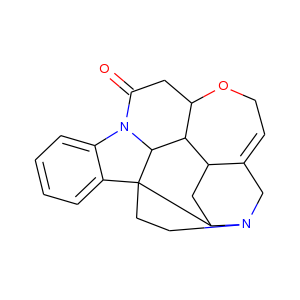

In [9]:
mol_noH = Chem.RemoveHs(mol)
Draw.MolToImage(mol_noH)

##### Could be better...

### 3D representation of molecule
_rendered in VMD, hydrogens removed for clarity_

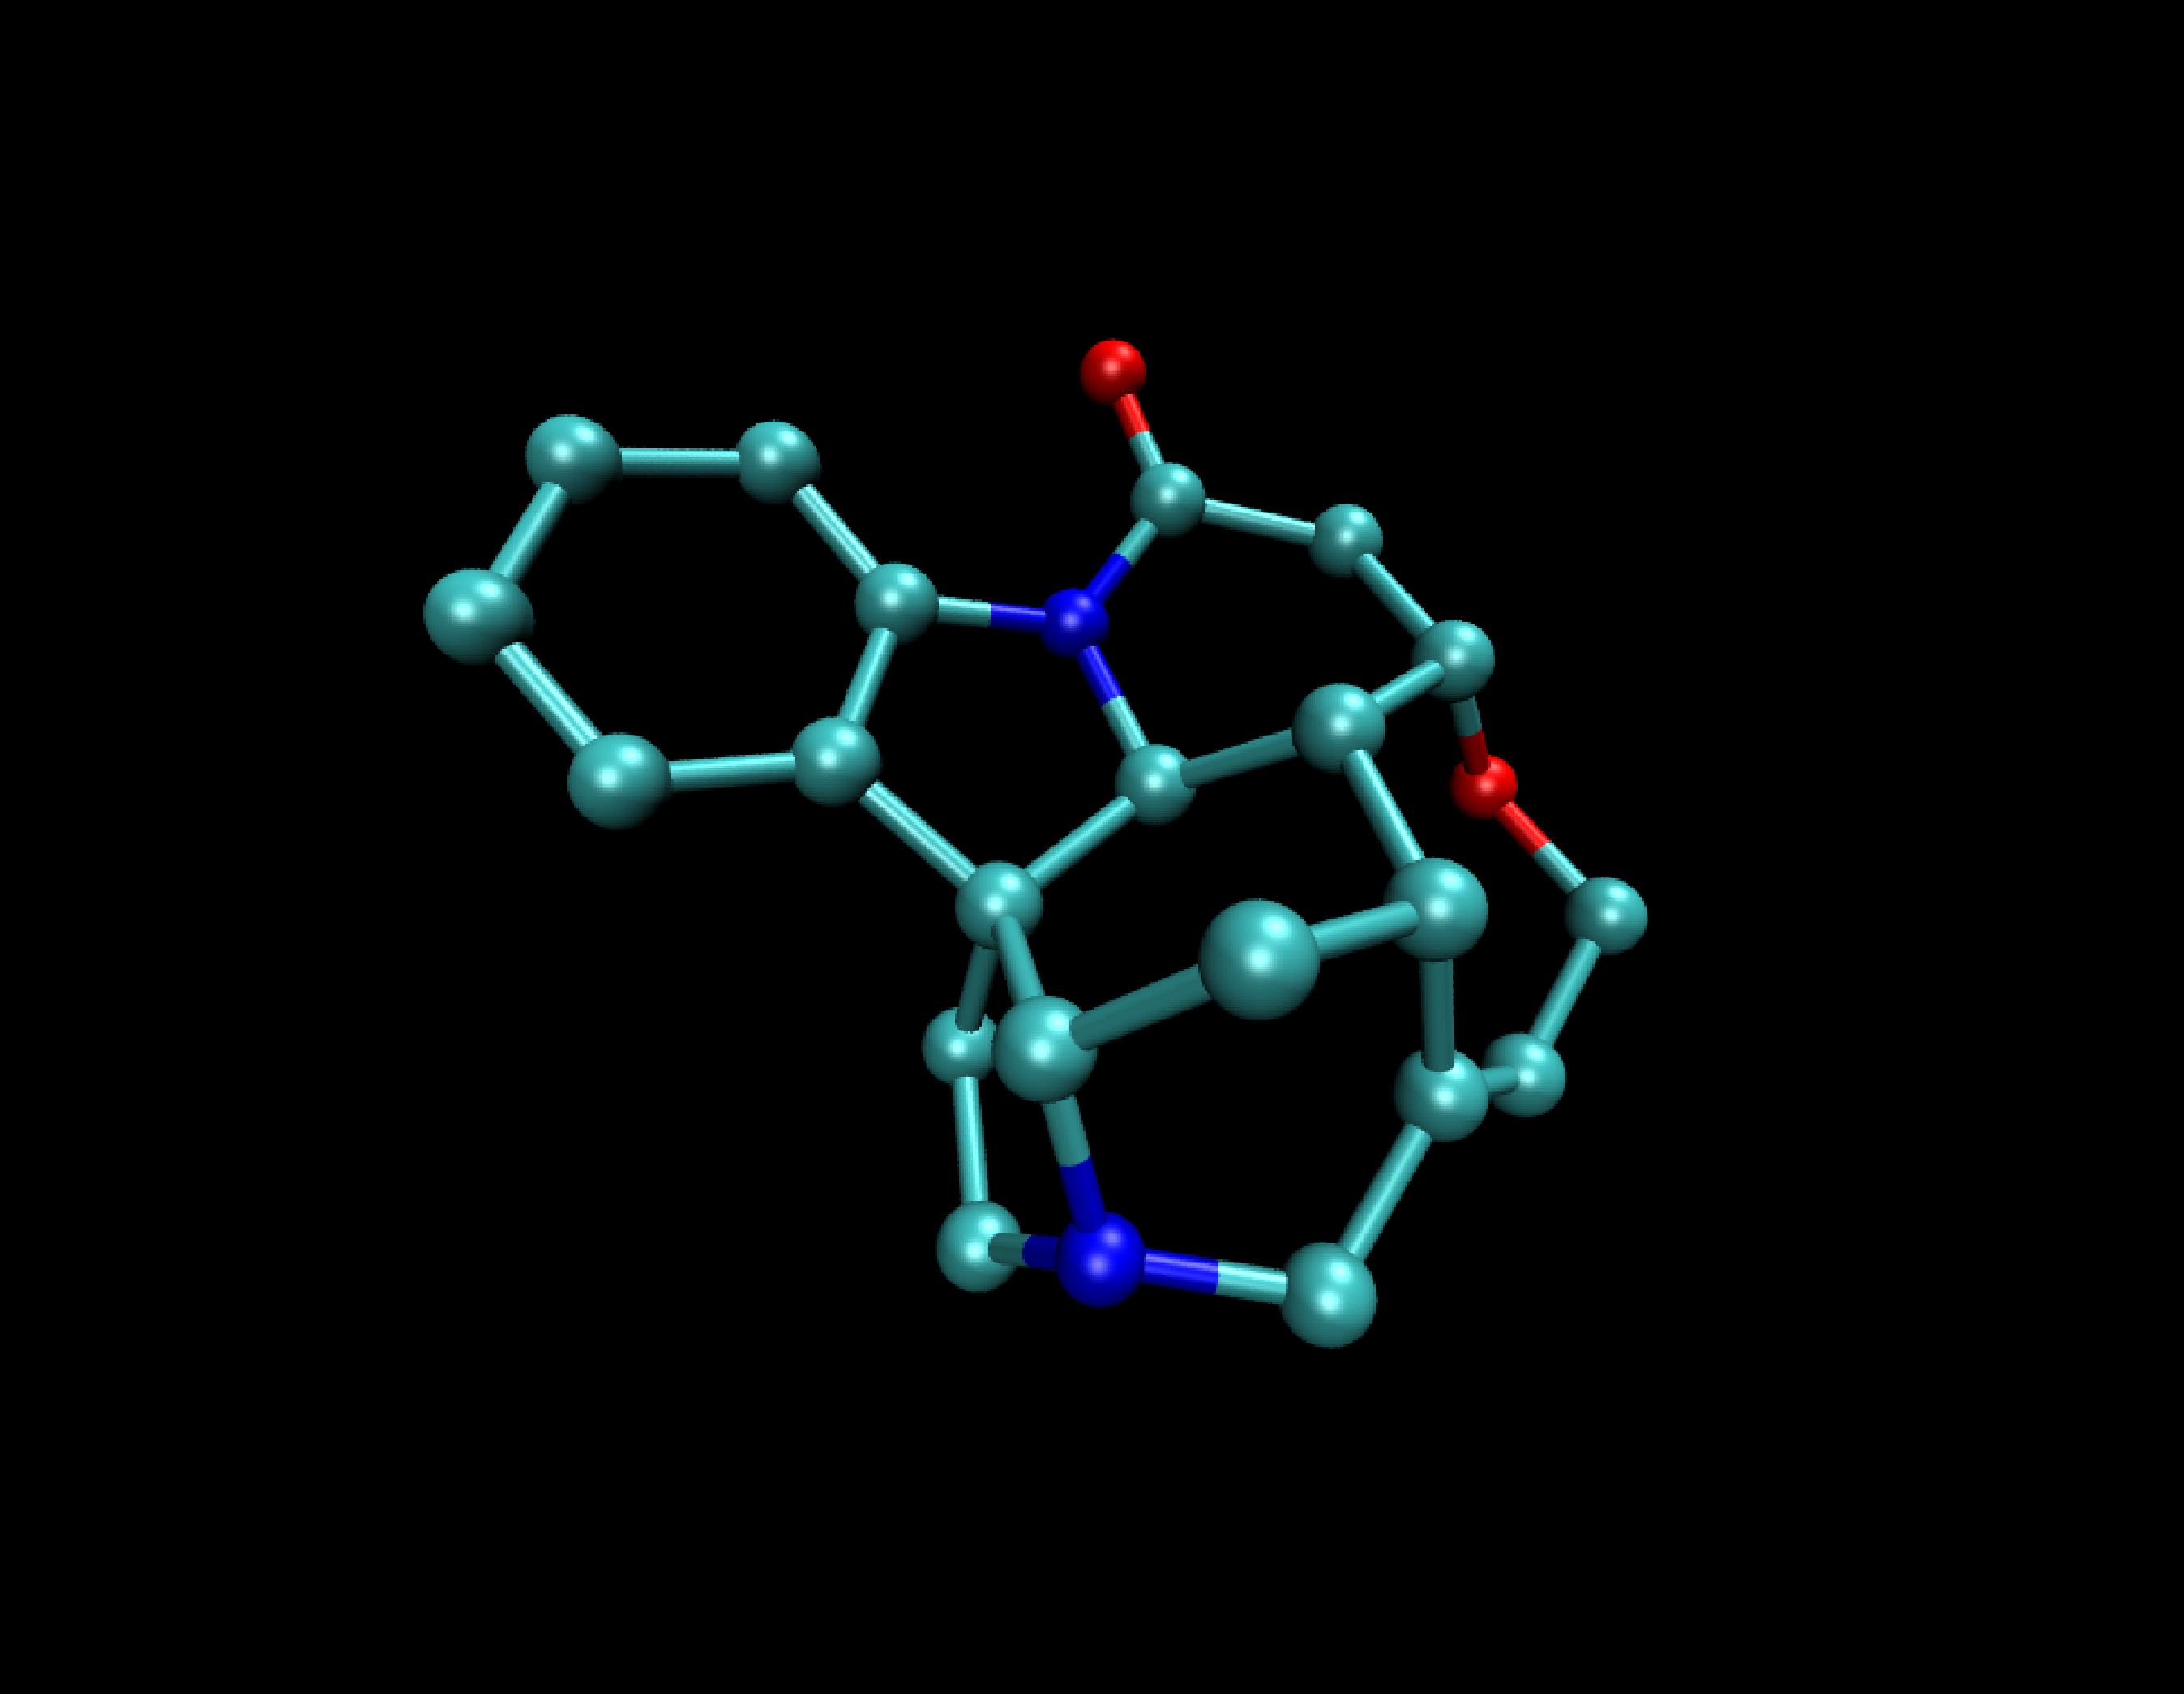

In [10]:
Image('mol.png', width=400)

### InChI and SMILES strings

In [11]:
print("InChI: {}".format(Chem.MolToInchi(mol_noH)))
print()
print("SMILES: {}".format(Chem.MolToSmiles(mol_noH)))

InChI: InChI=1S/C21H22N2O2/c24-18-10-16-19-13-9-17-21(6-7-22(17)11-12(13)5-8-25-16)14-3-1-2-4-15(14)23(18)20(19)21/h1-5,13,16-17,19-20H,6-11H2

SMILES: O=C1CC2OCC=C3CN4CCC56c7ccccc7N1C5C2C3CC46
